In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, InceptionV3, MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d trolukovich/food11-image-dataset

 99% 1.07G/1.08G [00:05<00:00, 244MB/s]
100% 1.08G/1.08G [00:05<00:00, 194MB/s]


In [ ]:
zip_path = "/content/food11-image-dataset.zip"  # Replace with the path to your uploaded zip file
extract_path = "/content/images"  # Replace with the desired folder path

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

### Using pre-trained CNN models

**ResNet-50**

In [ ]:
# Set the paths to your train, test, and validation directories
train_directory = "/content/images/training"
test_directory = "/content/images/evaluation"
validation_directory = "/content/images/validation"

# Set the image dimensions and other hyperparameters
img_height, img_width = 224, 224
batch_size = 32
epochs = 100  # Increase the number of epochs
num_classes = 11

# Use data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# For the test and validation sets, only rescale the pixel values
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Prepare the data generators
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

validation_generator = test_datagen.flow_from_directory(
    validation_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add a custom classifier on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)  # Add dropout layer
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the callbacks
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5)
early_stopping = EarlyStopping(patience=10)  # Early stopping
model_checkpoint = ModelCheckpoint("ResNet50.hdf5",verbose=1,save_best_only=True)  # Model checkpoint

# Train the model with callbacks
history=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[lr_callback, early_stopping, model_checkpoint]
)

# Load the best model saved during training
model.load_weights("ResNet50.hdf5")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:",test_accuracy)


Found 9866 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Epoch 1/100
308/308 [==============================] - ETA: 0s - loss: 3.2376 - accuracy: 0.4177
Epoch 1: val_loss improved from inf to 2.81750, saving model to ResNet50.hdf5
308/308 [==============================] - 288s 790ms/step - loss: 3.2376 - accuracy: 0.4177 - val_loss: 2.8175 - val_accuracy: 0.1460 - lr: 0.0010
Epoch 2/100
308/308 [==============================] - ETA: 0s - loss: 1.4308 - accuracy: 0.5992
Epoch 2: val_loss did not improve from 2.81750
308/308 [==============================] - 215s 698ms/step - loss: 1.4308 - accuracy: 0.5992 - val_loss: 3.2479 - val_accuracy: 0.1603 - lr: 0.0010
Epoch 3/100
308/308 [==============================] - ETA: 0s - loss: 1.1996 - accuracy: 0.6515
Epoch 3: val_loss improved from 2.81750 to 2.24309, saving model to ResNet50.hdf5
308/308 [==============================] - 238s 773ms/step - loss: 1.1996 - a

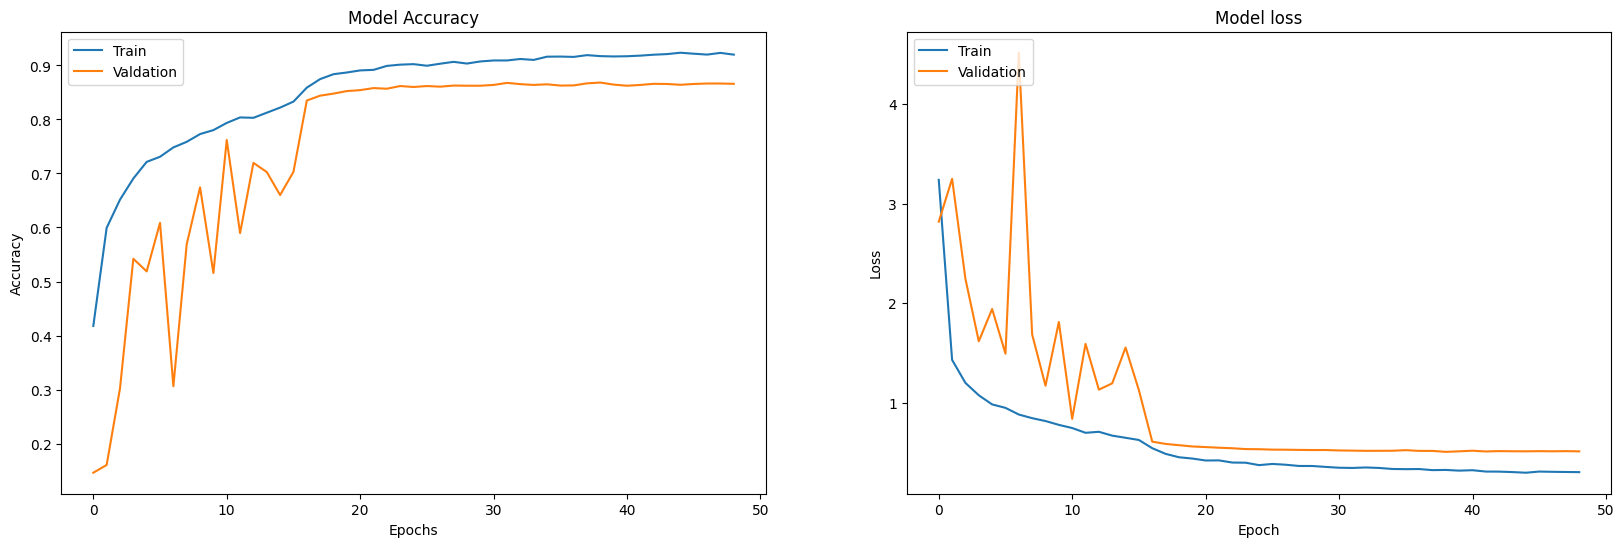

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Valdation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

**InceptionV3**

In [ ]:
# Set the paths to your train, test, and validation directories
train_directory = "/content/images/training"
test_directory = "/content/images/evaluation"
validation_directory = "/content/images/validation"

# Set the image dimensions and other hyperparameters
img_height, img_width = 224, 224
batch_size = 32
epochs = 100  # Increase the number of epochs
num_classes = 11

# Use data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# For the test and validation sets, only rescale the pixel values
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Prepare the data generators
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

validation_generator = test_datagen.flow_from_directory(
    validation_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the pre-trained InceptionV3 model without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add a custom classifier on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)  # Add dropout layer
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the callbacks
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5)
early_stopping = EarlyStopping(patience=10)  # Early stopping
model_checkpoint = ModelCheckpoint(filepath='InceptionV3_Model.hdf5',
                                  save_best_only=True,
                                  verbose=1)  # Model checkpoint
tensorboard = TensorBoard(log_dir = "logs/fit" , histogram_freq = 1)


# Train the model with callbacks
history=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[lr_callback, early_stopping, model_checkpoint,tensorboard]
)

# Load the best model saved during training
model.load_weights("InceptionV3_Model.hdf5")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Found 9866 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/100
308/308 [==============================] - ETA: 0s - loss: 2.5095 - accuracy: 0.5356
Epoch 1: val_loss improved from inf to 2.20953, saving model to InceptionV3_Model.hdf5
308/308 [==============================] - 299s 783ms/step - loss: 2.5095 - accuracy: 0.5356 - val_loss: 2.2095 - val_accuracy: 0.3429 - lr: 0.0010
Epoch 2/100
308/308 [==============================] - ETA: 0s - loss: 1.1938 - accuracy: 0.6652
Epoch 2: val_loss improved from 2.20953 to 1.82828, saving model to InceptionV3_Model.hdf5
308/308 [==============================] - 235s 762ms/step - loss: 1.1938 - accuracy: 0.6652 - val_loss: 1.8283 - val_accuracy: 0.5254 - lr: 0.0010
Epoch 3/100
308/308 [==============================] - ETA: 0s - loss: 1.0323 - accuracy: 0.7096
Epoch 3: val_loss improved from 1.82828 t

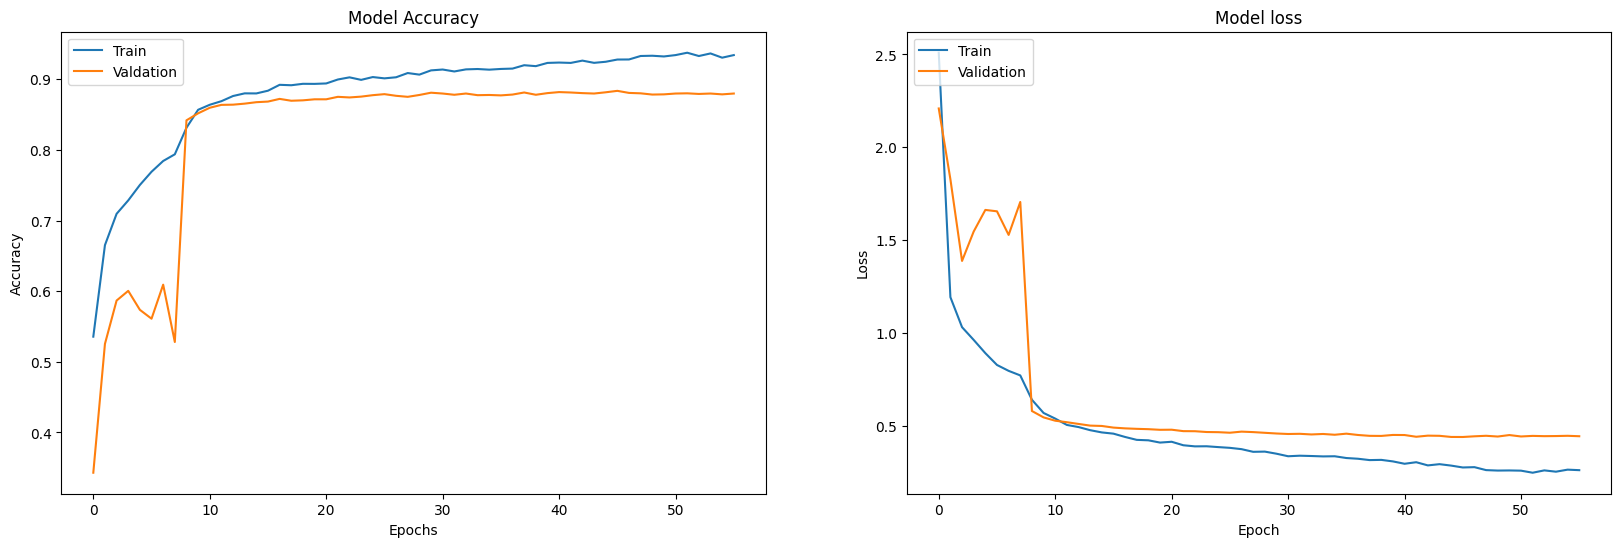

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Valdation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

**MobileNet**

In [ ]:
# Set the paths to your train, test, and validation directories
train_directory = "/content/images/training"
test_directory = "/content/images/evaluation"
validation_directory = "/content/images/validation"

# Set the image dimensions and other hyperparameters
img_height, img_width = 224, 224
batch_size = 32
epochs = 100  # Increase the number of epochs
num_classes = 11

# Use data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# For the test and validation sets, only rescale the pixel values
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Prepare the data generators
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

validation_generator = test_datagen.flow_from_directory(
    validation_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the pre-trained MobileNet model without the top layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add a custom classifier on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)  # Add dropout layer
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the callbacks
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5)
early_stopping = EarlyStopping(patience=10)  # Early stopping
model_checkpoint = ModelCheckpoint("Mobilenet_model.hdf5", save_best_only=True, verbose=1)  # Model checkpoint

# Train the model with callbacks
history=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[lr_callback, early_stopping, model_checkpoint]
)

# Load the best model saved during training
model.load_weights("Mobilenet_model.hdf5")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Found 9866 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Epoch 1/100
308/308 [==============================] - ETA: 0s - loss: 3.0322 - accuracy: 0.6294
Epoch 1: val_loss improved from inf to 2.57000, saving model to Mobilenet_model.hdf5
308/308 [==============================] - 220s 669ms/step - loss: 3.0322 - accuracy: 0.6294 - val_loss: 2.5700 - val_accuracy: 0.5003 - lr: 0.0010
Epoch 2/100
308/308 [==============================] - ETA: 0s - loss: 1.1656 - accuracy: 0.7498
Epoch 2: val_loss did not improve from 2.57000
308/308 [==============================] - 200s 650ms/step - loss: 1.1656 - accuracy: 0.7498 - val_loss: 6.4274 - val_accuracy: 0.2585 - lr: 0.0010
Epoch 3/100
308/308 [==============================] - ETA: 0s - loss: 0.8610 - accuracy: 0.7809
Epoch 3: val_loss improved from 2.57000 to 1.12538, saving model to Mobilenet_model.hdf5
308/308 [==============================] - 202s 655ms/step - lo

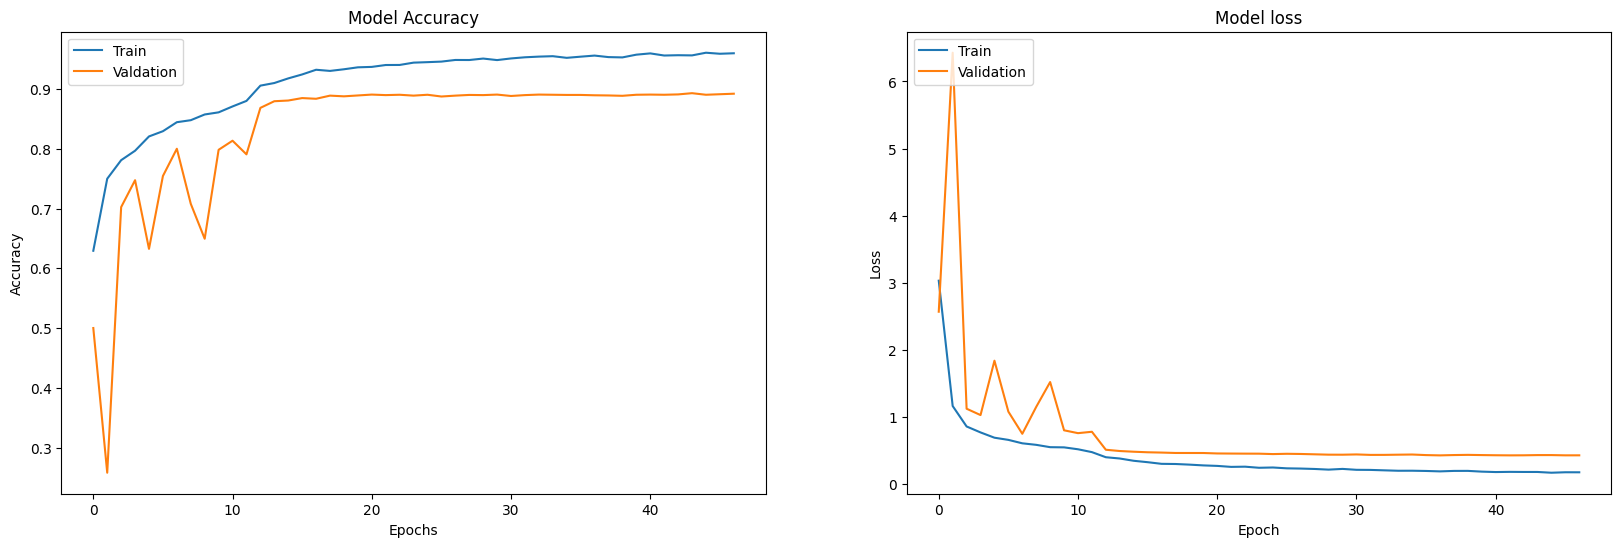

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Valdation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

**EfficientNet**

In [ ]:
pip install tensorflow==2.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Set the paths to your train, test, and validation directories
train_directory = "/content/images/training"
test_directory = "/content/images/evaluation"
validation_directory = "/content/images/validation"

# Set the image dimensions and other hyperparameters
img_height, img_width = 224, 224
batch_size = 32
epochs = 100  # Increase the number of epochs
num_classes = 11

# Use data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# For the test and validation sets, only rescale the pixel values
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Prepare the data generators
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

validation_generator = test_datagen.flow_from_directory(
    validation_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the pre-trained EfficientNetB0 model without the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add a custom classifier on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)  # Add dropout layer
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the callbacks
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5) # Reduce Learning Rate
early_stopping = EarlyStopping(patience=10)  # Early stopping
model_checkpoint = ModelCheckpoint("Efficientnet_model.hdf5", save_best_only=True,verbose=1)  # Model checkpoint

# Train the model with callbacks
history=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[lr_callback, early_stopping, model_checkpoint]
)

# Load the best model saved during training
model.load_weights("Efficientnet_model.hdf5")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Found 9866 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Epoch 1/100
308/308 [==============================] - ETA: 0s - loss: 2.2425 - accuracy: 0.6871
Epoch 1: val_loss improved from inf to 2.95109, saving model to Efficientnet_model.hdf5
308/308 [==============================] - 258s 779ms/step - loss: 2.2425 - accuracy: 0.6871 - val_loss: 2.9511 - val_accuracy: 0.0645 - lr: 0.0010
Epoch 2/100
308/308 [==============================] - ETA: 0s - loss: 0.8512 - accuracy: 0.7965
Epoch 2: val_loss did not improve from 2.95109
308/308 [==============================] - 228s 737ms/step - loss: 0.8512 - accuracy: 0.7965 - val_loss: 5.6015 - val_accuracy: 0.0660 - lr: 0.0010
Epoch 3/100
308/308 [==============================] - ETA: 0s - loss: 0.7225 - accuracy: 0.8306
Epoch 3: val_loss did not improve from 2.95109
308/308 [==============================] - 236s 765ms/step - loss: 0.7225 - accuracy: 0.8306 - val_los

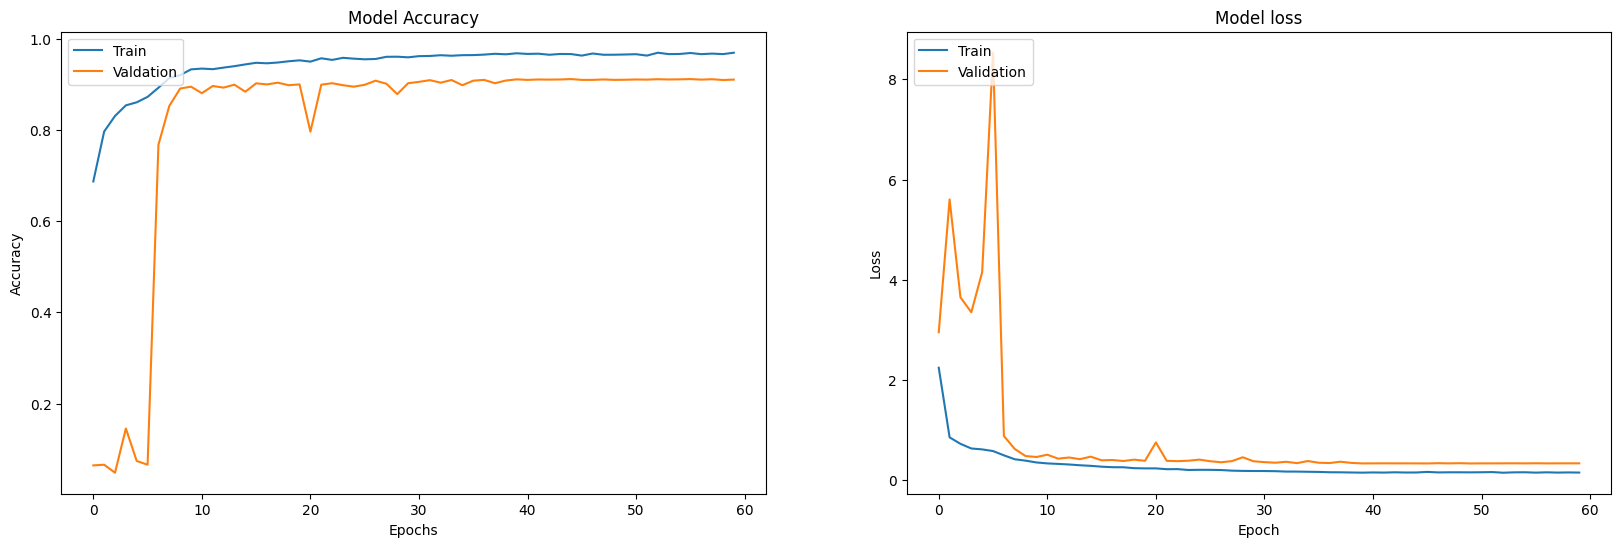

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Valdation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
from tabulate import tabulate

# Define the model names
model_names = ["ResNet-50", "InceptionNetV3", "MobileNet", "EfficientNetB0"]

# Define the performance metrics
train_loss = [0.3263, 0.2772, 0.1921, 0.1531]
train_accuracy = [0.9172, 0.9281, 0.9557, 0.9654]
val_loss = [0.5077, 0.4413, 0.4304, 0.3305]
val_accuracy = [0.8683, 0.8838, 0.8893, 0.9100]
test_loss = [0.42103099822998047, 0.38301804661750793, 0.36784806847572327, 0.2680100202560425]
test_accuracy = [0.8933373093605042, 0.8957275152206421, 0.9076785445213318, 0.9333731532096863]

# Create the table
table_data = list(zip(model_names, train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy))
table_headers = ["Model", "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy", "Test Loss", "Test Accuracy"]
table = tabulate(table_data, headers=table_headers, floatfmt=".4f", tablefmt="grid")

# Print the table
print(table)

+----------------+--------------+------------------+-------------------+-----------------------+-------------+-----------------+
| Model          |   Train Loss |   Train Accuracy |   Validation Loss |   Validation Accuracy |   Test Loss |   Test Accuracy |
+================+==============+==================+===================+=======================+=============+=================+
| ResNet-50      |       0.3263 |           0.9172 |            0.5077 |                0.8683 |      0.4210 |          0.8933 |
+----------------+--------------+------------------+-------------------+-----------------------+-------------+-----------------+
| InceptionNetV3 |       0.2772 |           0.9281 |            0.4413 |                0.8838 |      0.3830 |          0.8957 |
+----------------+--------------+------------------+-------------------+-----------------------+-------------+-----------------+
| MobileNet      |       0.1921 |           0.9557 |            0.4304 |                0.8893 | 

**Final Observations and Conclusions:**
1. Among all of the models, EfficientNetB0 consistently outperforms the other models. It achieves the lowest test loss and highest test accuracy which is our main focus. Therefore, EfficientNetB0 demonstrates superior performance compared to ResNet-50, InceptionNetV3, and MobileNet.

2.  All models exhibit a good level of generalization as indicated by their high validation and test accuracies. This suggests that the models are able to effectively generalize from the training data to correctly classify unseen data instances. The test accuracies of all models are above 0.89, indicating their ability to perform well on unseen test data.

3. The models vary in their complexity and size. ResNet-50 and InceptionNetV3 are relatively deeper and more complex models compared to MobileNet and EfficientNetB0. Despite being simpler, MobileNet and EfficientNetB0 achieve comparable or better performance in terms of accuracy and loss. This indicates that these models are more efficient in terms of computational resources while maintaining competitive performance.

4.  None of the models demonstrate significant signs of overfitting as the validation and test accuracies are close to the training accuracy. The differences between training and validation/test accuracies are relatively small, suggesting that the models are not excessively memorizing the training data and can generalize well to unseen data.

5. EfficientNetB0 stands out as the best-performing model in terms of both accuracy and loss metrics. It achieves the highest validation and test accuracies while maintaining the lowest validation and test losses. Therefore, it can be concluded that EfficientNetB0 is the most effective model among the listed options for the given classification task.
